In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [2]:
raw_data = pd.read_csv('car_sales.csv')
df = raw_data.copy()

#### Dropping Model column and null records

In [3]:
df = df.drop(columns='Model')
df = df.dropna(axis=0)

In [4]:
df.describe()

,Price,Mileage,EngineV,Year
count,4025.000000,4025.000000,4025.000000,4025.000000
mean,19552.308065,163.572174,2.764586,2006.379627
std,25815.734988,103.394703,4.935941,6.695595
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,90.000000,1.800000,2003.000000
50%,11500.000000,158.000000,2.200000,2007.000000
75%,21900.000000,230.000000,3.000000,2012.000000
max,300000.000000,980.000000,99.990000,2016.000000


#### Handling Outliers

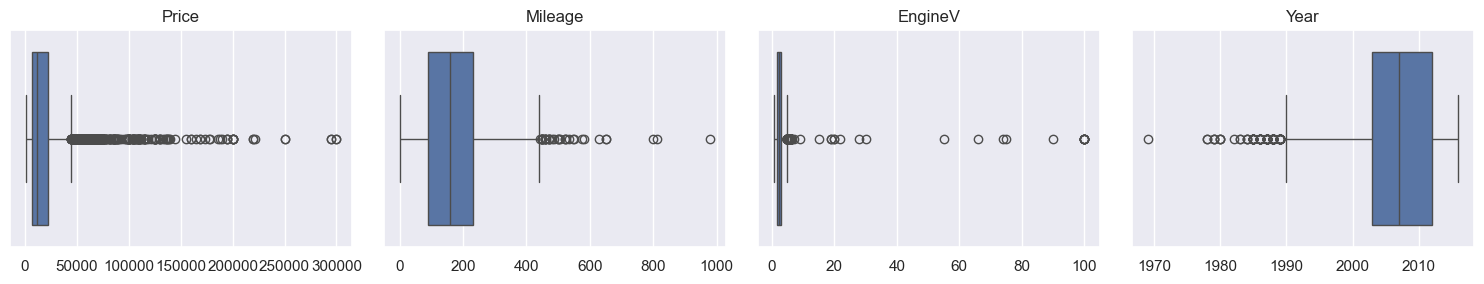

In [5]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.subplots(1,4,figsize=(15,3))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df[column])
    plt.title(column)
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [6]:
df_outliers = df.copy()

In [7]:
enginevuqr = df['EngineV'].quantile(.75)
enginevuqr

3.0

#### Reasoning for outliers

###### Price
Clearly the data includes some top-end cars, or some erroneous data. While it's not impossible that cars are being sold for $300,000, it seems less likely to be included in used car sales (although, having never bought, sold, or owned a luxury sports car, it's hard for me to say... do people just take these to local dealer when they've had their fun? It seems unlikely).

Will drop under 200k and log transform to stabilise variance.

###### Mileage
Average mileage per year in the UK is around 6,000 miles. I'd imagine this is higher in the US, so looking at the means from the data, an average mileage per year of around 8,500 miles is found. So, the scale is x1000. Again, it wouldn't be impossible for a 30yo car to do 1 million miles, but research shows that around 300,000 is seen as a very impressive milestone to reach, requiring proper care and maintenance to reach.

Apply cap at 500k.

###### EngineV
The Upper quartile range is exactly 3 here, engines above this size are less common, in the UK at least, but can easily get much higher.

Apply cap at 7.

##### Year
There are few outliers on the lower end of the data, so I'd feel comfortable using IQR here. Either they're classic cars with a higher value, which will distort the data, or they're just very old cars.

#### Price

In [8]:
df_outliers = df_outliers[df_outliers['Price'] <= 200000]

In [9]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,4016.000000,4016.000000,4016.000000,4016.000000
mean,19010.518167,163.880229,2.757809,2006.364293
std,23108.950597,103.300955,4.939352,6.694509
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,90.000000,1.800000,2003.000000
50%,11500.000000,158.500000,2.200000,2007.000000
75%,21700.000000,230.000000,3.000000,2012.000000
max,200000.000000,980.000000,99.990000,2016.000000


#### Mileage

In [10]:
df_outliers = df_outliers[df_outliers['Mileage'] <= 500]

In [11]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,4000.00000,4000.000000,4000.000000,4000.000000
mean,19033.08524,162.064750,2.759490,2006.390500
std,23124.48087,99.082001,4.948941,6.676425
min,600.00000,0.000000,0.600000,1969.000000
25%,6999.75000,90.000000,1.800000,2003.000000
50%,11500.00000,158.000000,2.200000,2007.500000
75%,21700.00000,230.000000,3.000000,2012.000000
max,200000.00000,500.000000,99.990000,2016.000000


#### EngineV

In [12]:
df_outliers = df_outliers[df_outliers['EngineV'] <= 7]

In [13]:
df_outliers.describe()

,Price,Mileage,EngineV,Year
count,3978.000000,3978.000000,3978.000000,3978.000000
mean,19097.339105,161.866264,2.460742,2006.406737
std,23169.081300,99.127441,0.964430,6.675983
min,600.000000,0.000000,0.600000,1969.000000
25%,7000.000000,90.000000,1.800000,2003.000000
50%,11500.000000,157.000000,2.200000,2008.000000
75%,21875.000000,230.000000,3.000000,2012.000000
max,200000.000000,500.000000,6.500000,2016.000000


#### Year

In [14]:
df_year = df_outliers.copy()

q1 = df_year['Year'].quantile(.25)
q3 = df_year['Year'].quantile(.75)

IQR = q3 - q1

df_year = df_year[df_year['Year'] >= q1 - 1.5 * IQR]

In [15]:
df_year.describe()

,Price,Mileage,EngineV,Year
count,3881.000000,3881.000000,3881.000000,3881.000000
mean,19498.770964,160.040196,2.472077,2006.911878
std,23308.938316,97.476806,0.969875,5.912460
min,800.000000,0.000000,0.600000,1990.000000
25%,7300.000000,90.000000,1.800000,2003.000000
50%,11800.000000,156.000000,2.200000,2008.000000
75%,22000.000000,225.000000,3.000000,2012.000000
max,200000.000000,500.000000,6.500000,2016.000000


In [16]:
df_year.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011


In [17]:
df_year.reset_index(drop=True)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011
...,...,...,...,...,...,...,...,...
3876,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008
3877,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014
3878,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014
3879,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999


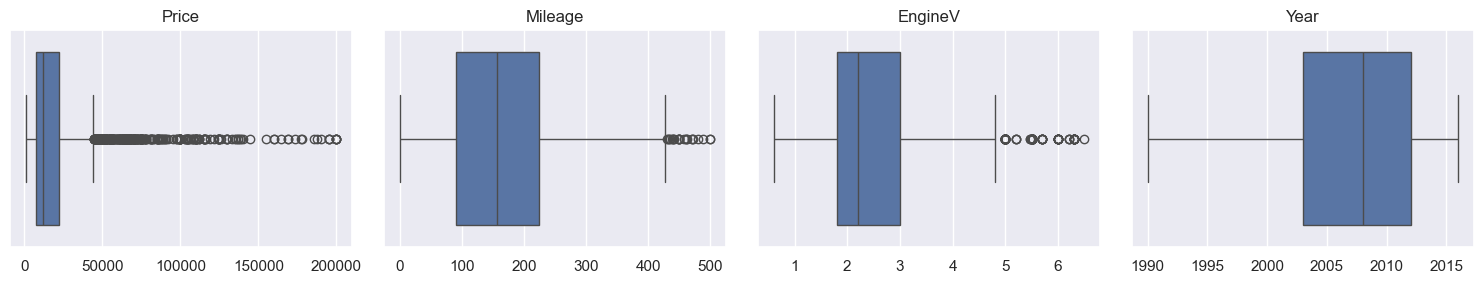

In [18]:
numerical_columns = df_year.select_dtypes(include=['float64', 'int64']).columns

plt.subplots(1,4,figsize=(15,3))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df_year[column])
    plt.title(column)
    plt.xlabel('')

plt.tight_layout()
plt.show()

#### Evaluation

Boxplots look far better now, except for price, will check again for log_price

In [19]:
df = df_year.copy()

#### Checking OLS

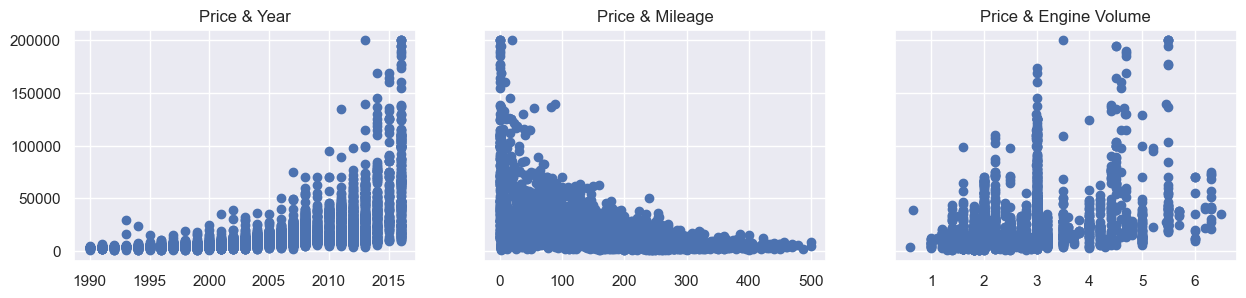

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True, figsize=(15,3))
ax1.scatter(df['Year'],df['Price'])
ax1.set_title('Price & Year')
ax2.scatter(df['Mileage'],df['Price'])
ax2.set_title('Price & Mileage')
ax3.scatter(df['EngineV'],df['Price'])
ax3.set_title('Price & Engine Volume')

plt.show()

In [21]:
log_price = np.log(df['Price'])
df['log_price'] = log_price
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,9.814656


<Axes: xlabel='log_price'>

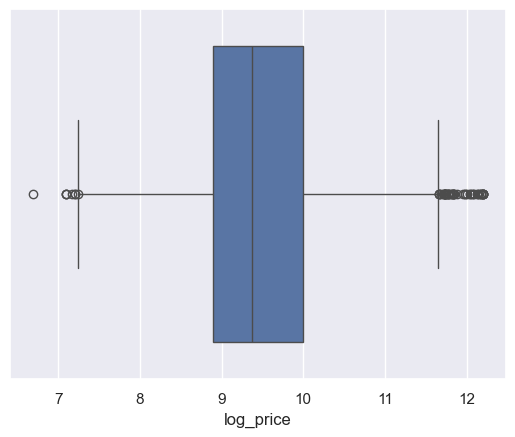

In [22]:
sns.boxplot(x=df['log_price'])

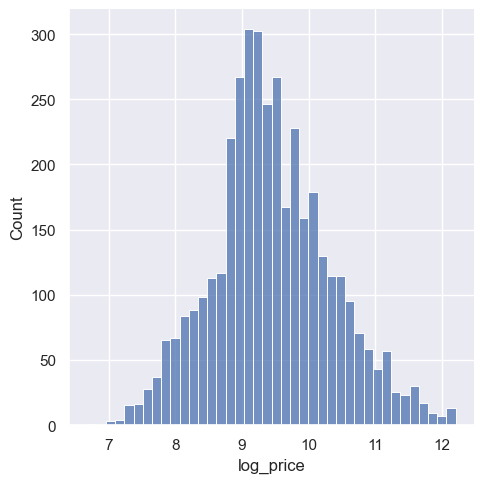

In [23]:
sns.displot(df['log_price'])

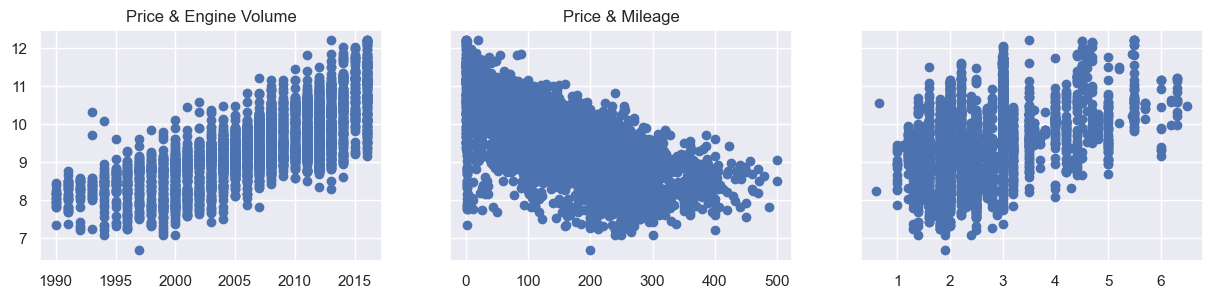

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True, figsize=(15,3))
ax1.scatter(df['Year'],df['log_price'])
ax1.set_title('Price & Year')
ax2.scatter(df['Mileage'],df['log_price'])
ax2.set_title('Price & Mileage')
ax3.scatter(df['EngineV'],df['log_price'])
ax1.set_title('Price & Engine Volume')

plt.show()

In [25]:
df_log = df.drop(columns='Price')

#### Checkpoint

Will probably make mistakes from here on out, so let's get some checkpoints going

In [26]:
df_dummy_check = df.copy()

#### Dummies

In [27]:
numerical = df.select_dtypes(include=['float64', 'int64'])
categorical = df.select_dtypes(include=['object','category'])

dummy = pd.concat([numerical, pd.get_dummies(categorical, drop_first=True).astype(int)], axis=1)
dummy.head()

,Price,Mileage,EngineV,Year,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,4200.0,277,2.0,1991,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,7900.0,427,2.9,1999,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,13300.0,358,5.0,2003,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,23000.0,240,4.2,2007,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,18300.0,120,2.0,2011,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [28]:
df = dummy.copy()

#### F-Reg

In [29]:
from sklearn.feature_selection import f_regression

In [30]:
df.columns

Index(['Price', 'Mileage', 'EngineV', 'Year', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype='object')

In [31]:
df = df.drop(columns='Price')

In [32]:
targets = df['log_price']
features = df[['Mileage', 'EngineV', 'Year', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']]

In [33]:
f_stats, p_stats = f_regression(features,targets)

In [34]:
freg_summary = pd.DataFrame(data=features.columns.values, columns=['Features'])

In [35]:
freg_summary['p_values'] = p_stats.round(3)

In [36]:
freg_summary

,Features,p_values
0,Mileage,0.000
1,EngineV,0.000
2,Year,0.000
3,Brand_BMW,0.000
4,Brand_Mercedes-Benz,0.000
5,Brand_Mitsubishi,0.000
6,Brand_Renault,0.000
7,Brand_Toyota,0.000
8,Brand_Volkswagen,0.000
9,Body_hatch,0.000


#### VIF Check

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif['Features'] = features.columns
vif

,VIF,Features
0,4.663189,Mileage
1,12.001178,EngineV
2,44.188968,Year
3,2.620111,Brand_BMW
4,3.189111,Brand_Mercedes-Benz
5,1.952237,Brand_Mitsubishi
6,2.450522,Brand_Renault
7,2.495890,Brand_Toyota
8,3.461293,Brand_Volkswagen
9,1.666593,Body_hatch


In [38]:
features_2 = features.drop(columns='Year')

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(features_2.values, i) for i in range(features_2.shape[1])]
vif['features_2'] = features_2.columns
vif

,VIF,features_2
0,4.312197,Mileage
1,7.790747,EngineV
2,2.287717,Brand_BMW
3,2.956077,Brand_Mercedes-Benz
4,1.639358,Brand_Mitsubishi
5,2.090909,Brand_Renault
6,2.173361,Brand_Toyota
7,2.843048,Brand_Volkswagen
8,1.447896,Body_hatch
9,1.529809,Body_other


#### Scaling

In [40]:
target = df['log_price']
features = df[['Mileage', 'EngineV', 'Year', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol']]

In [42]:
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()

In [43]:
scaler2.fit(features)

StandardScaler()

In [44]:
features_scaled2 = scaler2.transform(features)

#### TT Split

In [47]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_scaled2, targets, test_size=0.2, random_state=42)

#### Regression

In [48]:
reg2 = LinearRegression()

In [49]:
reg2.fit(x_train, y_train)

LinearRegression()

In [50]:
r2 = reg2.score(x_train,y_train)
n = x_train.shape[0]
p = x_train.shape[1]
r2

0.8172790900298363

In [51]:
r2adj = 1 - (1 - r2) * (n-1) / (n-p-1)
r2adj

0.8162725263650623

#### $R^2$-adj of 0.82 > 0.77

Succesful model adjustment

#### Benchmarks

In [55]:
df_bench = df.copy()

df.columns.values

array(['Mileage', 'EngineV', 'Year', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [57]:
raw_data['Brand'].unique()

array(['BMW', 'Mercedes-Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

In [58]:
raw_data['Body'].unique()

array(['sedan', 'van', 'crossover', 'vagon', 'other', 'hatch'],
      dtype=object)

In [59]:
benchmarks = {'Brand':'Audi', 'Body':'crossover', 'Engine Type':'Diesel'}

In [65]:
y_hat = reg2.predict(x_train)

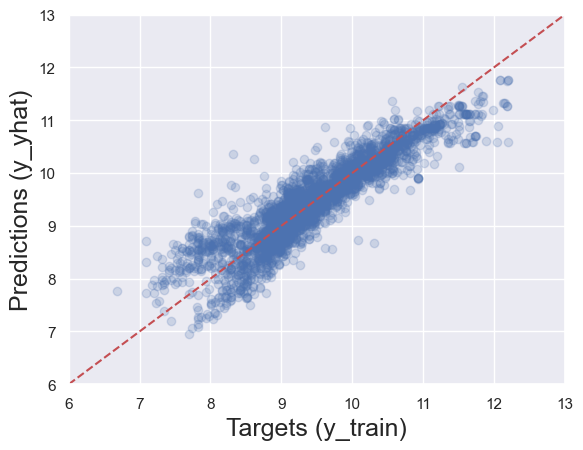

In [69]:
plt.scatter(y_train, y_hat, alpha=.2)
plt.xlabel('Targets (y_train)', size=18)
plt.ylabel('Predictions (y_yhat)', size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.plot([6, 13], [6, 13], 'r--')
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

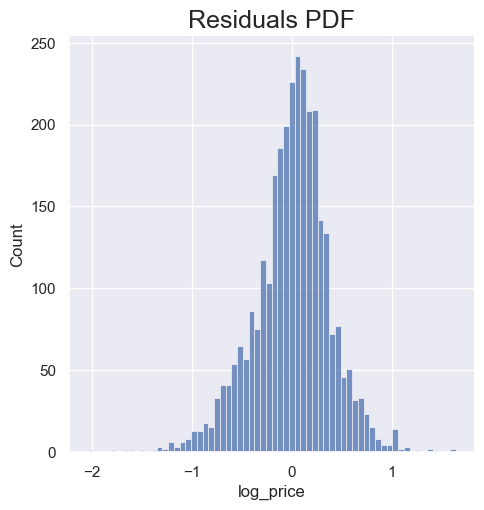

In [71]:
sns.displot(y_train - y_hat)
plt.title("Residuals PDF", size=18)

#### Result

Scatter: Can see some under-prediction at the higher end. The 'mouth' at the lower end seems to roughly average out.

Distribution: Definitely some left skew, but far less than seen previously. This likely counteracts the mode being slightly > 0 to lower the mean.

#### Weight & Bias

The weight on Year is comparatively tremendous, likely where most of the predictive power is coming from.

The main option I'd like to try next is to keep the registration and see the effect it has

In [74]:
reg_summary = pd.DataFrame(features.columns.values, columns=['Features'])
reg_summary['Weights'] = reg2.coef_
reg_summary

,Features,Weights
0,Mileage,-0.115682
1,EngineV,0.250307
2,Year,0.576281
3,Brand_BMW,0.030426
4,Brand_Mercedes-Benz,0.036046
5,Brand_Mitsubishi,-0.106458
6,Brand_Renault,-0.173037
7,Brand_Toyota,-0.050422
8,Brand_Volkswagen,-0.071065
9,Body_hatch,-0.097978


#### Testing

In [76]:
y_hat_test = reg2.predict(x_test)

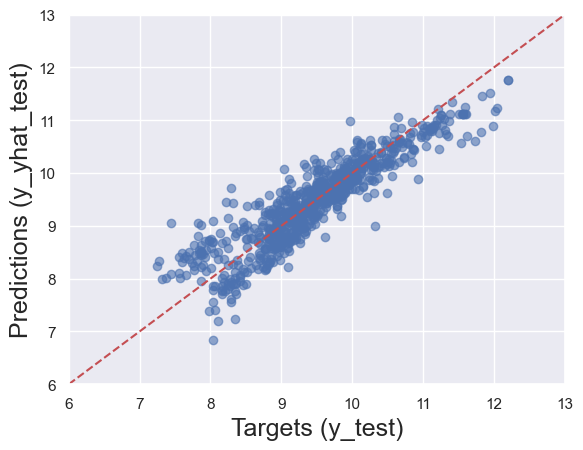

In [77]:
plt.scatter(y_test, y_hat_test, alpha=.6)
plt.xlabel('Targets (y_test)', size=18)
plt.ylabel('Predictions (y_yhat_test)', size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.plot([6, 13], [6, 13], 'r--')
plt.show()

In [78]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns = ['Predictions'])
df_pf.head()

,Predictions
0,6626.103133
1,23809.273448
2,4482.047491
3,10811.342167
4,5380.211546


In [79]:
y_test_ind = y_test.reset_index(drop=True)
y_test_ind.head()

0    9.210240
1    9.035987
2    7.919356
3    8.974618
4    8.961879
Name: log_price, dtype: float64

In [80]:
df_pf['Target'] = np.exp(y_test_ind)
df_pf

,Predictions,Target
0,6626.103133,9999.0
1,23809.273448,8400.0
2,4482.047491,2750.0
3,10811.342167,7900.0
4,5380.211546,7800.0
...,...,...
772,6129.625290,2750.0
773,11017.880056,6800.0
774,9065.306263,9200.0
775,7067.924996,8500.0


In [81]:
df_pf['Residuals'] = df_pf['Target'] - df_pf['Predictions']
df_pf

,Predictions,Target,Residuals
0,6626.103133,9999.0,3372.896867
1,23809.273448,8400.0,-15409.273448
2,4482.047491,2750.0,-1732.047491
3,10811.342167,7900.0,-2911.342167
4,5380.211546,7800.0,2419.788454
...,...,...,...
772,6129.625290,2750.0,-3379.625290
773,11017.880056,6800.0,-4217.880056
774,9065.306263,9200.0,134.693737
775,7067.924996,8500.0,1432.075004


In [82]:
df_pf['Residuals%'] = np.absolute(df_pf['Residuals']/df_pf['Target'] * 100)
df_pf

,Predictions,Target,Residuals,Residuals%
0,6626.103133,9999.0,3372.896867,33.732342
1,23809.273448,8400.0,-15409.273448,183.443732
2,4482.047491,2750.0,-1732.047491,62.983545
3,10811.342167,7900.0,-2911.342167,36.852432
4,5380.211546,7800.0,2419.788454,31.022929
...,...,...,...,...
772,6129.625290,2750.0,-3379.625290,122.895465
773,11017.880056,6800.0,-4217.880056,62.027648
774,9065.306263,9200.0,134.693737,1.464062
775,7067.924996,8500.0,1432.075004,16.847941


In [83]:
df_pf.describe()

,Predictions,Target,Residuals,Residuals%
count,777.000000,777.000000,777.000000,777.000000
mean,17585.957027,19802.697027,2216.740000,31.691706
std,15939.555403,24228.042600,11831.731352,36.560064
min,934.087167,1400.000000,-37191.863299,0.062550
25%,7211.791284,7500.000000,-2222.331903,10.592970
50%,12826.639179,12300.000000,459.738264,22.610134
75%,22396.147388,21900.000000,2805.249113,37.157093
max,127374.976540,199999.000000,106392.440411,400.274021


In [85]:
pd.options.display.max_rows = 999
df_pf.sort_values(by=['Residuals%'])

,Predictions,Target,Residuals,Residuals%
161,32920.578878,32900.00,-20.578878,0.062550
568,19474.108560,19500.00,25.891440,0.132777
377,11869.606583,11900.00,30.393417,0.255407
682,6721.062200,6700.00,-21.062200,0.314361
405,26750.340418,26850.00,99.659582,0.371172
571,23245.973040,23333.00,87.026960,0.372978
128,7531.460349,7499.00,-32.460349,0.432862
252,18602.671385,18700.00,97.328615,0.520474
506,17605.210153,17700.00,94.789847,0.535536
21,9150.409973,9100.00,-50.409973,0.553956


#### Conclusion

An improvement across the board, with the mean residual% down almost 10% and the maximum error down from 1600% to 400%.

Again, we see overprediction on the lower end, making up most of the more severe errors. As stated previously, car damage could be a factor driving this, for which I do not have data.

#### Improvement

As stated previously, I will attempt to model again, including the registration status. Despite its high VIF and low variability, it does carry significant weight. I'm not sure on the process of vehicle registration in the US, but I imagine it carries a time and monetary cost to resolve, which may well drive down the price significantly, especially on cheaper vehicles.